# Camera Calbration

## Have the camera matrix and distortion coefficients been computed correctly and checked on one of the calibration images as a test?

This part is based upon - https://github.com/udacity/CarND-Camera-Calibration

### Imports

In [46]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob

plt.style.use('seaborn-white')

### Setup Variables

In [47]:
inner_chessboard_corners = (9,6)
camera_calibration_images = 'camera_cal/calibra*.jpg'
camera_calibration_pickle = 'dist_pickle.p'
camera_calibration_example = 'camera_cal/calibration1.jpg'
camera_calibration_example_out = 'output_images/calibration1_undist.jpg'

### Create objpoints & imgpoints

In [48]:
objp = np.zeros((inner_chessboard_corners[1]*inner_chessboard_corners[0],3), np.float32)
objp[:,:2] = np.mgrid[0:inner_chessboard_corners[0], 0:inner_chessboard_corners[1]].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob(camera_calibration_images)

for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    ret, corners = cv2.findChessboardCorners(gray, inner_chessboard_corners, None)

    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)


### Output Original & Undistorted Chessboard

In [49]:
%matplotlib inline

# Test undistortion on an image
img = cv2.imread(camera_calibration_example)
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite(camera_calibration_example_out,dst)

True

In [50]:
# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
dist_pickle["objpoints"] = objpoints
dist_pickle["imgpoints"] = imgpoints
pickle.dump( dist_pickle, open(camera_calibration_pickle, "wb" ) )

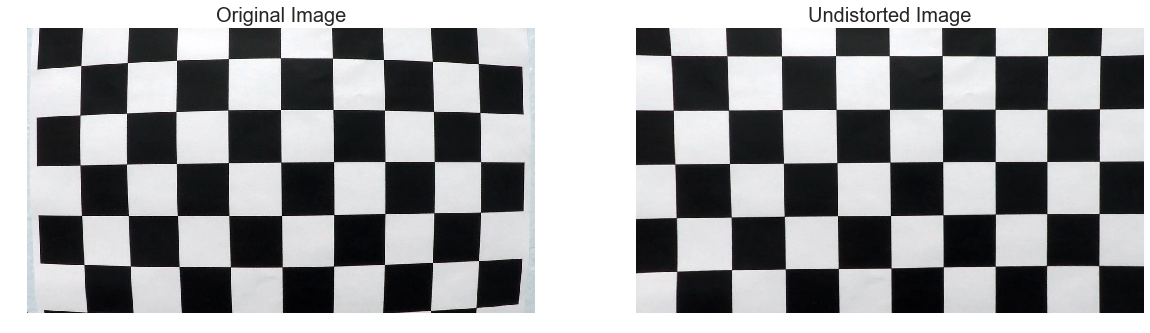

In [53]:
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.axis('off')
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(dst)
ax2.axis('off')
ax2.set_title('Undistorted Image', fontsize=20)

# Pipeline (single images)

This part is my own implementation, following the lectures and applying differnent kind of variables.

### Imports

In [54]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

### Setup Variables

In [55]:
test_image = "test_images/test3.jpg"
test_image_output = "output_images/test3_undist.jpg"
dashboard_crop = 50

### Load dist_pickle

In [56]:
dist_pickle = pickle.load( open(camera_calibration_pickle, "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]
objpoints = dist_pickle["objpoints"]
imgpoints = dist_pickle["imgpoints"]

### Image processing pipeline functions

In [57]:
def pipeline(img, mtx, dist, dashboard_crop=50):
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    crop = dst[0:dst.shape[0]-dashboard_crop, 0:dst.shape[1]]
    
    return crop

## 1. Has the distortion correction been correctly applied to each image?

In [58]:
# Test undistortion on an image and write it to disk
img = cv2.imread(test_image)

dst = pipeline(img, mtx, dist)
cv2.imwrite(test_image_output, dst)

True

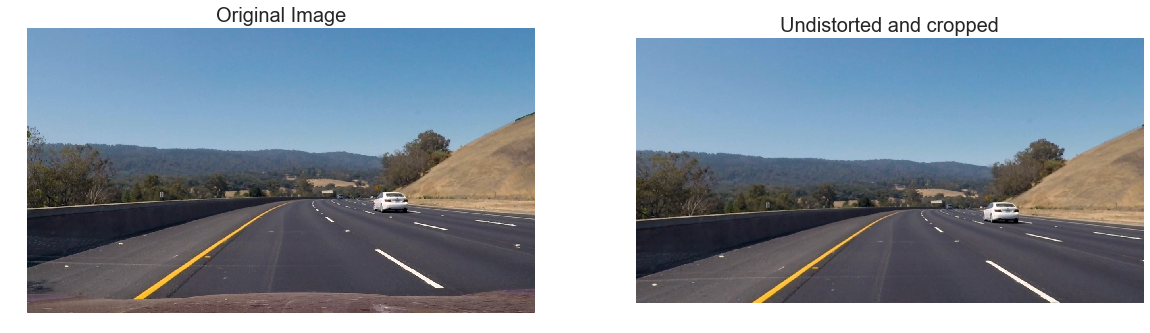

In [59]:

# Visualize undistortion
img = mpimg.imread(test_image)
test_img = mpimg.imread(test_image_output)

%matplotlib inline
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.axis('off')
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(test_img, cmap='gray')
ax2.axis('off')
ax2.set_title('Undistorted and cropped', fontsize=20)


## Has a binary image been created using color transforms, gradients or other methods?

### Imports

In [60]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob

### Setup Variables

In [61]:
test_undist = "output_images/test3_undist.jpg"
test_undist_gradx = "output_images/test3_undist_gradx.jpg"
test_undist_grady = "output_images/test3_undist_grady.jpg"
test_undist_mag_binary = "output_images/test3_undist_mag_binary.jpg"
test_undist_dir_binary = "output_images/test3_undist_dir_binary.jpg"
test_undist_color_binary = "output_images/test3_undist_color_binary.jpg"
test_undist_combined = "output_images/test3_undist_combined.jpg"

### Create combined threshold

In [62]:
# Define a function that takes an image, gradient orientation,
# and threshold min / max values.
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output

In [63]:
# Define a function to return the magnitude of the gradient
# for a given sobel kernel size and threshold values
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output


In [64]:
# Define a function to threshold an image for a given range and Sobel kernel
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

In [65]:
def color_thresh(img, s_thresh=(200, 255), sx_thresh=(50, 100)):
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))

    return color_binary

In [66]:
def hls_select(img, thresh=(0, 255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]
    # 2) Apply a threshold to the S channel
    bin = np.zeros_like(S)
    bin[(S > thresh[0]) & (S <= thresh[1])] = 1
    return bin

In [67]:
def bin_to_rgb(bin_image):
    return cv2.cvtColor(bin_image*255, cv2.COLOR_GRAY2RGB)

def hls_to_rgb(hlsimage):
    return cv2.cvtColor(hlsimage, cv2.COLOR_HLS2RGB)

In [68]:
ksize = 5
threshold=(25, 80)

mag_sobel_kernel = 9
mag_threshold=(40, 100)

binary_sobel_kernel = 15
binary_mag_threshold=(0.7, 1.3)

s_thresh=(200, 255)
sx_thresh=(50, 100)

In [69]:
def create_binary(img):
    img = np.copy(img)
    
    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=ksize, thresh=threshold)
    grady = abs_sobel_thresh(img, orient='y', sobel_kernel=ksize, thresh=threshold)
    mag_binary = mag_thresh(img, sobel_kernel=mag_sobel_kernel, mag_thresh=mag_threshold)
    dir_binary = dir_threshold(img, sobel_kernel=binary_sobel_kernel, thresh=binary_mag_threshold)
    color_binary = color_thresh(img, s_thresh=s_thresh, sx_thresh=sx_thresh)
    
    return (gradx, grady, mag_binary, dir_binary, color_binary)

img = mpimg.imread(test_image_output)
gradx, grady, mag_binary, dir_binary, color_binary = create_binary(img)

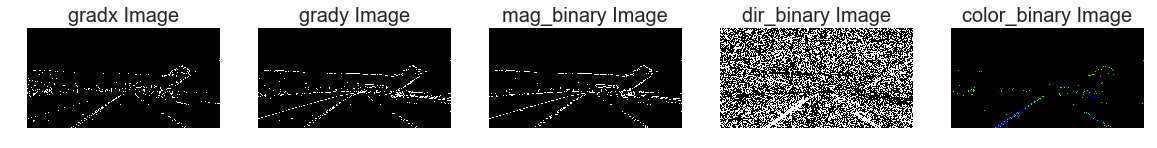

In [70]:
%matplotlib inline
# Visualize undistortion
f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(20,10))
ax1.imshow(gradx, cmap='gray')
ax1.axis('off')
ax1.set_title('gradx Image', fontsize=20)
ax2.imshow(grady, cmap='gray')
ax2.axis('off')
ax2.set_title('grady Image', fontsize=20)
ax3.imshow(mag_binary, cmap='gray')
ax3.axis('off')
ax3.set_title('mag_binary Image', fontsize=20)
ax4.imshow(dir_binary, cmap='gray')
ax4.axis('off')
ax4.set_title('dir_binary Image', fontsize=20)
ax5.imshow(color_binary)
ax5.axis('off')
ax5.set_title('color_binary Image', fontsize=20)

In [71]:
cv2.imwrite(test_undist_gradx, bin_to_rgb(gradx))
cv2.imwrite(test_undist_grady, bin_to_rgb(grady))
cv2.imwrite(test_undist_mag_binary, bin_to_rgb(mag_binary))
cv2.imwrite(test_undist_dir_binary, bin_to_rgb(np.uint8(dir_binary)))
cv2.imwrite(test_undist_color_binary, np.uint8(color_binary)) # Don't know, why the written file is just black....

True

## Build Pipeline 

In [72]:
def create_combined(img):
    ksize = 31
    thresh_sobel = (50, 150)
    thresh_mag = (50, 255)
    thresh_dir = (0.75, 1.15)

    # Gradient, Magnitude, Direction Thresholds
    gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=ksize, thresh=thresh_sobel)
    mag_bin = mag_thresh(img, sobel_kernel=ksize, mag_thresh=thresh_mag)
    dir_bin = dir_threshold(img, sobel_kernel=ksize, thresh=thresh_dir)

    # Combine Thresholds 1
    comb_bin = np.zeros_like(gradx)
    comb_bin[(gradx == 1) | ((dir_bin == 1) & (mag_bin == 1))] = 1

    # Color Threshold S-channel
    thresh_s = (170, 255)

    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)        
    img_color = hls[:,:,2]

    color_bin = np.zeros_like(img_color)
    color_bin[(img_color > thresh_s[0]) & (img_color <= thresh_s[1])] = 1

    # Color Threshold R-channel
    thresh_r = (200, 255)
    r_img = img[:,:,0]

    r_bin = np.zeros_like(r_img)
    r_bin[(r_img > thresh_r[0]) & (r_img <= thresh_r[1])] = 1

    # Combined Gradient/Mag + Color S + Color R
    combined = np.zeros_like(comb_bin)
    combined[(comb_bin == 1) | (color_bin == 1) | (r_bin == 1)] = 1
    
    return combined

In [73]:
def pipeline_combined(img, mtx, dist, dashboard_crop=50):
    combined = create_combined(img) 
    return combined

True

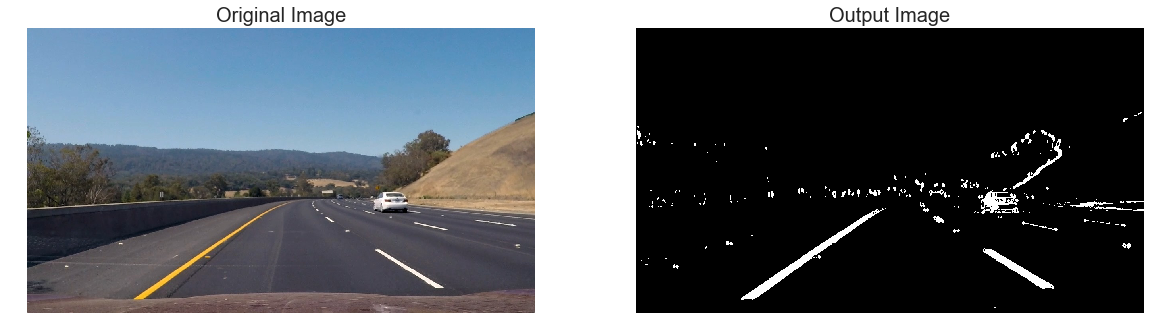

In [74]:
dist_pickle = pickle.load( open(camera_calibration_pickle, "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]
objpoints = dist_pickle["objpoints"]
imgpoints = dist_pickle["imgpoints"]

img = mpimg.imread(test_image)
out = pipeline_combined(img, mtx, dist, dashboard_crop=50)

%matplotlib inline
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.axis('off')
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(out, cmap="gray")
ax2.axis('off')
ax2.set_title('Output Image', fontsize=20)

cv2.imwrite(test_undist_combined, bin_to_rgb(out))


## Has a perspective transform been applied to rectify the image?

### Setup Variables

In [75]:
test_undist_transformed = "output_images/test3_undist_transformed.jpg"
test_warped = "output_images/test3_warped.jpg"
test_binary_warped = "output_images/test3_binary_warped.jpg"

### Perspective transform

In [76]:
dist_pickle = pickle.load( open(camera_calibration_pickle, "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]
objpoints = dist_pickle["objpoints"]
imgpoints = dist_pickle["imgpoints"]

img = mpimg.imread(test_image)
pipelined = pipeline(img, mtx, dist, dashboard_crop=50)

In [77]:
def warp(img, src, dst, M):
    img_size = (img.shape[1], img.shape[0])
    
    return cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

In [93]:
src = np.float32([
    [730, 460],
    [1035, pipelined.shape[0] - 10],
    [310, pipelined.shape[0] - 10], 
    [610, 460]
])

dst = np.float32([
    [1000, 100],
    [1000, 600], 
    [400, 600], 
    [400, 100]
])


M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)

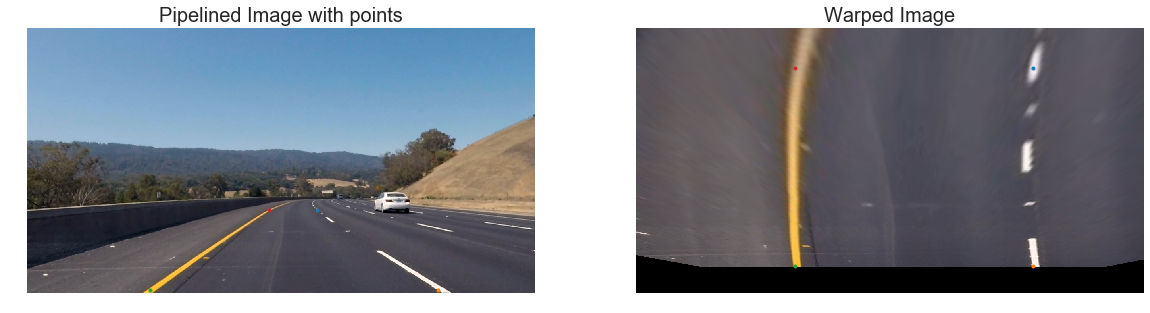

In [94]:
warped = warp(pipelined, src, dst, M)

cv2.imwrite(test_warped, warped)

%matplotlib inline
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))

ax1.imshow(pipelined)
ax1.axis('off')
ax1.plot(src[0][0], src[0][1], '.') # top right
ax1.plot(src[1][0], src[1][1], '.') # bottom right
ax1.plot(src[2][0], src[2][1], '.') # bottom left
ax1.plot(src[3][0], src[3][1], '.') # top left
ax1.set_title('Pipelined Image with points', fontsize=20)

ax2.imshow(warped)
ax2.axis('off')
ax2.plot(dst[0][0], dst[0][1], '.') # top right
ax2.plot(dst[1][0], dst[1][1], '.') # bottom right
ax2.plot(dst[2][0], dst[2][1], '.') # bottom left
ax2.plot(dst[3][0], dst[3][1], '.') # top left
ax2.set_title('Warped Image', fontsize=20)

### Pipeline with combined binary

True

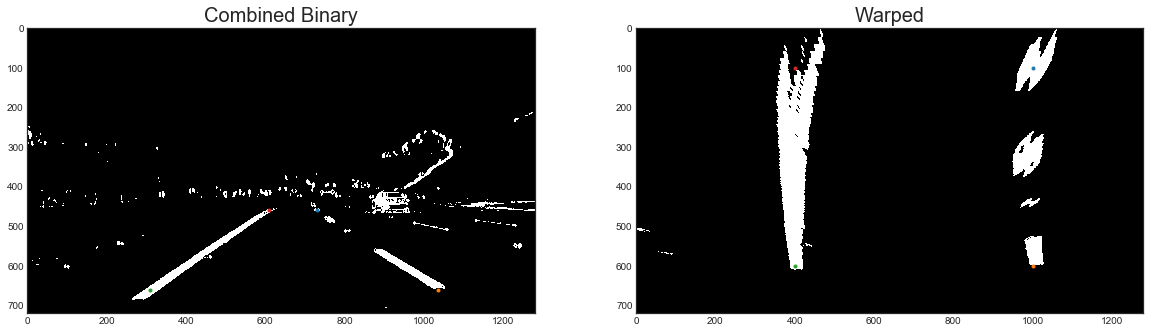

In [108]:
dist_pickle = pickle.load( open(camera_calibration_pickle, "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]
objpoints = dist_pickle["objpoints"]
imgpoints = dist_pickle["imgpoints"]

img = mpimg.imread(test_image)
binary_combined = pipeline_combined(img, mtx, dist, dashboard_crop=50)
binary_warped = warp(binary_combined, src, dst, M)

%matplotlib inline
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))

ax1.imshow(binary_combined, cmap="gray")
ax1.plot(src[0][0], src[0][1], '.') # top right
ax1.plot(src[1][0], src[1][1], '.') # bottom right
ax1.plot(src[2][0], src[2][1], '.') # bottom left
ax1.plot(src[3][0], src[3][1], '.') # top left

ax1.set_title('Combined Binary', fontsize=20)

ax2.imshow(binary_warped, cmap="gray")
ax2.plot(dst[0][0], dst[0][1], '.') # top right
ax2.plot(dst[1][0], dst[1][1], '.') # bottom right
ax2.plot(dst[2][0], dst[2][1], '.') # bottom left
ax2.plot(dst[3][0], dst[3][1], '.') # top left
ax2.set_title('Warped', fontsize=20)

cv2.imwrite(test_binary_warped, bin_to_rgb(binary_warped))

## Have lane line pixels been identified in the rectified image and fit with a polynomial?

### Setup Variables

In [109]:
test_histogram = "output_images/test3_histogram.jpg"
test_sliding_window = "output_images/test3_sliding_window.jpg"
test_skip_sliding_window = "test_images/test4.jpg"
test_skip_sliding_window_output = "output_images/test4_sliding_window.jpg"
test_fake_data_output = "output_images/test4_fake_data.jpg"
test_overlay_output = "output_images/test4_overlay.jpg"
test_composed_output = "output_images/test4_composed.jpg"

### Line Finding Method: Peaks in a Histogram

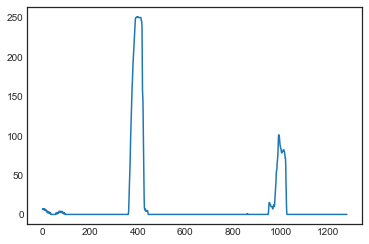

In [118]:
dist_pickle = pickle.load( open(camera_calibration_pickle, "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]
objpoints = dist_pickle["objpoints"]
imgpoints = dist_pickle["imgpoints"]

img = mpimg.imread(test_image)
binary_combined = pipeline_combined(img, mtx, dist, dashboard_crop=50)
binary_warped = warp(binary_combined, src, dst, M)

histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
plt.plot(histogram)
plt.savefig(test_histogram)


In [120]:
midpoint = np.int(histogram.shape[0] / 2)

# get left and right halves of the histogram
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

print('Left Peak: {}'.format(leftx_base))
print('Right Peak: {}'.format(rightx_base))

Left Peak: 397
Right Peak: 992


### Sliding Window

Based on - https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/2b62a1c3-e151-4a0e-b6b6-e424fa46ceab/lessons/40ec78ee-fb7c-4b53-94a8-028c5c60b858/concepts/c41a4b6b-9e57-44e6-9df9-7e4e74a1a49a

In [111]:
# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)

# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 10
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

### Visualization

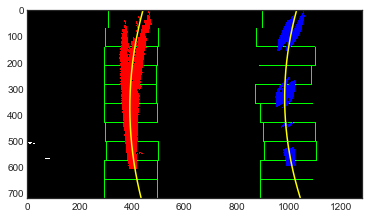

In [112]:
# Generate x and y values for plotting
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

plt.savefig(test_sliding_window)


### Skip Sliding Window

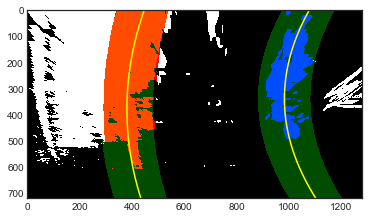

In [113]:
img = mpimg.imread(test_skip_sliding_window)
binary_combined = pipeline_combined(img, mtx, dist, dashboard_crop=50)
binary_warped = warp(binary_combined, src, dst, M)

# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
margin = 100
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]
# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

plt.savefig(test_skip_sliding_window_output)

## Having identified the lane lines, has the radius of curvature of the road been estimated? And the position of the vehicle with respect to center in the lane?


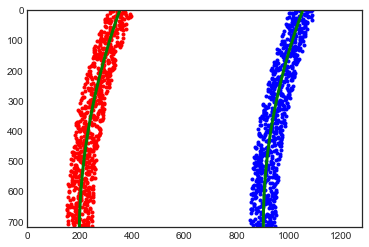

In [114]:
ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
# For each y position generate random x position within +/-50 pix
# of the line base position in each case (x=200 for left, and x=900 for right)
leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                              for y in ploty])
rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                for y in ploty])

leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
rightx = rightx[::-1]  # Reverse to match top-to-bottom in y


# Fit a second order polynomial to pixel positions in each fake lane line
left_fit = np.polyfit(ploty, leftx, 2)
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fit = np.polyfit(ploty, rightx, 2)
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Plot up the fake data
mark_size = 3
plt.plot(leftx, ploty, 'o', color='red', markersize=mark_size)
plt.plot(rightx, ploty, 'o', color='blue', markersize=mark_size)
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(left_fitx, ploty, color='green', linewidth=3)
plt.plot(right_fitx, ploty, color='green', linewidth=3)
plt.gca().invert_yaxis() # to visualize as we do the images

plt.savefig(test_fake_data_output)

In [115]:
# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])

print(left_curverad, right_curverad)

# Example values: 1711.78110073 2076.59826391

1819.70526774 1662.20723394


In [154]:
def curve_rad(fit, y):
    return ((1 + (2*fit[0]*y + fit[1])**2)**1.5) / np.absolute(2*fit[0])

def get_curve_rad(ploty, leftx, rightx, y_eval):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 21/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    return (left_curverad, right_curverad)

left_curverad, right_curverad = get_curve_rad(ploty, leftx, rightx, y_eval)
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')

292.730266178 m 267.504341874 m


In [161]:
def get_lane_deviation(image_size, center):
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    lane_deviation = (center - image_size[1] / 2.0) * xm_per_pix
    return lane_deviation;


center = img.shape[0] / 2
print(get_lane_deviation(img.shape, center), 'cm')

-1.48 cm


# Pipeline (video)

### Imports

In [117]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

### Setup Variables


In [128]:
project_video = 'project_video.mp4'
challenge_video = 'challenge_video.mp4'
harder_challenge_video = 'harder_challenge_video.mp4'

project_video_output = 'output_videos/project_video_output.mp4'
challenge_video_output = 'output_videos/challenge_video_output.mp4'
harder_challenge_video_output = 'output_videos/harder_challenge_video_output.mp4'

### Line Class

In [194]:
class Line:
    def __init__(self, mtx, dist, objpoints, imgpoints, src, dst, sampling=0.1):
        self.mtx = mtx
        self.dist = dist
        self.objpoints = objpoints
        self.imgpoints = imgpoints
        self.sampling = sampling
        self.src = src
        self.dst = dst
        
        self.distance_to_center = 0
        self.left_curvature = 0
        self.right_curvature = 0
        self.counter = 0
        self.dashboard_crop = 50
        self.detected = False
        self.left_fit = None
        self.right_fit = None
        self.img = None
        self.binary_warped = None
        
        self.M = cv2.getPerspectiveTransform(src, dst)
        self.Minv = cv2.getPerspectiveTransform(dst, src)
        
    def find_sliding_window(self, binary_warped):
        # Assuming you have created a warped binary image called "binary_warped"
        # Take a histogram of the bottom half of the image
        histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)

        # Create an output image to draw on and  visualize the result
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]/2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        # Choose the number of sliding windows
        nwindows = 10
        # Set height of windows
        window_height = np.int(binary_warped.shape[0]/nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base
        # Set the width of the windows +/- margin
        margin = 100
        # Set minimum number of pixels found to recenter window
        minpix = 50
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 

        self.detected = True
        
        return leftx, lefty, rightx, righty
        
    def skip_sliding_window(self, binary_warped):
        left_fit = self.left_fit 
        right_fit = self.right_fit
        
        # Assume you now have a new warped binary image 
        # from the next frame of video (also called "binary_warped")
        # It's now much easier to find line pixels!
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        margin = 80
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

        # Again, extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        
        return leftx, lefty, rightx, righty

        
    def fit_poly(self, image, leftx, lefty, rightx, righty):
        # Fit a second order polynomial to each
        ploty = np.linspace(0, 719, num=720)
        left_fit = np.polyfit(lefty, leftx, 2)
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fit = np.polyfit(righty, rightx, 2)
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        return left_fit, left_fitx, right_fit, right_fitx
    
    def process(self, img):
        self.img = np.copy(img)
        self.binary_combined = pipeline_combined(self.img, self.mtx, self.dist, dashboard_crop=self.dashboard_crop)
        self.binary_warped = warp(self.binary_combined, self.src, self.dst, self.M)
        
        if self.detected:
            leftx, lefty, rightx, righty = self.skip_sliding_window(self.binary_warped)
        else:
            leftx, lefty, rightx, righty = self.find_sliding_window(self.binary_warped)
            
        left_fit, left_fitx, right_fit, right_fitx = self.fit_poly(self.img, leftx, lefty, rightx, righty)
        ploty = np.linspace(0, 719, num=720)
        # Define conversions in x and y from pixels space to meters
        ym_per_pix = 30/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/700 # meters per pixel in x dimension
        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
        # Calculate the new radii of curvature
        y_eval = np.max(ploty)
        self.left_curvature = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        self.right_curvature = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
      
        left_mean = np.mean(leftx)
        right_mean = np.mean(rightx)
        camera_pos = (self.binary_combined.shape[1]/2)-np.mean([left_mean, right_mean])
        self.distance_to_center = np.round(camera_pos*xm_per_pix,2)
        
        warp_zero = np.zeros_like(self.binary_warped).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
        
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))
        # Draw the lane onto the warped blank image
        cv2.fillPoly(warp_zero, np.int_([pts]), (0,255, 0))
        
        self.warp_inv = cv2.warpPerspective(warp_zero, self.Minv, (self.img.shape[1], self.img.shape[0])) 
        result = cv2.addWeighted(self.img, 1, self.warp_inv, 0.3, 0)
            
        font = cv2.FONT_HERSHEY_SIMPLEX 
        curvature_text = 'Left Curvature: {:.3f} m Right Curvature: {:.3f} m'.format(self.left_curvature, self.right_curvature)
        cv2.putText(self.img, curvature_text, (50, 50), font, 1, (255, 0, 0), 2)
        deviation_info = 'Lane Deviation: {:.3f} m'.format(self.distance_to_center)
        cv2.putText(self.img, deviation_info, (50, 90), font, 1, (255, 0, 0), 2)
        
        return self.img
        

dist_pickle = pickle.load( open(camera_calibration_pickle, "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]
objpoints = dist_pickle["objpoints"]
imgpoints = dist_pickle["imgpoints"]

src = np.float32([
    [735, 460],
    [1035, pipelined.shape[0] - 10],
    [300, pipelined.shape[0] - 10], 
    [600, 460]
])

dst = np.float32([
    [1000, 100],
    [1000, 700], 
    [400, 700], 
    [400, 100]
])

line = Line(mtx, dist, objpoints, imgpoints, src, dst)

clip = VideoFileClip(project_video)
clip = clip.subclip(t_start=40, t_end=41)
# clip = clip.subclip(t_start=39, t_end=39.2)
# clip = clip.subclip(t_start=5, t_end=5.2)
# clip = clip.subclip(t_start=35, t_end=35.2)
# clip = clip.subclip(t_start=35, t_end=36)
print('Duration: ', clip.duration)
output_clip = clip.fl_image(line.process)
output_clip.write_videofile(project_video_output, audio=False)



Duration:  1


error: /Users/jenkins/miniconda/1/x64/conda-bld/conda_1486587097465/work/opencv-3.1.0/modules/core/src/arithm.cpp:639: error: (-209) The operation is neither 'array op array' (where arrays have the same size and the same number of channels), nor 'array op scalar', nor 'scalar op array' in function arithm_op


### Process video 